# Crucible 3 vs 4: Reproducibility Check

**Purpose:** Verify that the first 500 steps of Crucible 4 exactly match Crucible 3.

Both runs used:
- Same random seed (42)
- Same hyperparameters (lr=1e-3, wd=0.0)
- Same model architecture
- Same dataset

**Expected result:** W[0:501], h_mean[0:500], and loss[0:501] should be bit-for-bit identical.

If they match: we have reproducible training dynamics and can trust Crucible 4's extended data.

If they don't: something broke (non-determinism, data shuffling issue, etc.).

## Setup

In [1]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path

# Plot styling
import matplotlib.pyplot as plt
STEELBLUE = '#4682B4'
plt.rcParams['figure.dpi'] = 200

## Load Data

In [3]:
PROJECT_ROOT = Path.cwd().parent.parent.parent.parent

crucible_3_path = PROJECT_ROOT / 'box_4' / 'tensors' / 'Crucible-3' / 'crucible_3_trajectory.safetensors'
crucible_4_path = PROJECT_ROOT / 'box_4' / 'tensors' / 'Crucible-4' / 'crucible_4_trajectory.safetensors'

print(f"Loading Crucible 3: {crucible_3_path}")
data_3 = load_file(str(crucible_3_path))

print(f"Loading Crucible 4: {crucible_4_path}")
data_4 = load_file(str(crucible_4_path))

print("\nCrucible 3 shapes:")
print(f"  W: {data_3['W'].shape}")
print(f"  h_mean: {data_3['h_mean'].shape}")
print(f"  loss: {data_3['loss'].shape}")

print("\nCrucible 4 shapes:")
print(f"  W: {data_4['W'].shape}")
print(f"  h_mean: {data_4['h_mean'].shape}")
print(f"  loss: {data_4['loss'].shape}")

Loading Crucible 3: /Users/jefferyharrell/Projects/Azimuth_II/box_4/tensors/Crucible-3/crucible_3_trajectory.safetensors
Loading Crucible 4: /Users/jefferyharrell/Projects/Azimuth_II/box_4/tensors/Crucible-4/crucible_4_trajectory.safetensors

Crucible 3 shapes:
  W: torch.Size([501, 10000, 64])
  h_mean: torch.Size([500, 64])
  loss: torch.Size([501])

Crucible 4 shapes:
  W: torch.Size([5001, 10000, 64])
  h_mean: torch.Size([5000, 64])
  loss: torch.Size([5001])


## Extract First 500 Steps from Crucible 4

In [4]:
# Crucible 3: all data (501 snapshots, 500 h_mean, 501 loss)
W_3 = data_3['W']  # (501, 10000, 64) uint16
h_mean_3 = data_3['h_mean']  # (500, 64) float32
loss_3 = data_3['loss']  # (501,) float32

# Crucible 4: first 501 snapshots (to match Crucible 3's length)
W_4 = data_4['W'][:501]  # (501, 10000, 64) uint16
h_mean_4 = data_4['h_mean'][:500]  # (500, 64) float32
loss_4 = data_4['loss'][:501]  # (501,) float32

print("Extracted first 500 steps from Crucible 4")
print(f"  W_4: {W_4.shape}")
print(f"  h_mean_4: {h_mean_4.shape}")
print(f"  loss_4: {loss_4.shape}")

Extracted first 500 steps from Crucible 4
  W_4: torch.Size([501, 10000, 64])
  h_mean_4: torch.Size([500, 64])
  loss_4: torch.Size([501])


## Comparison: W (Embedding Weights)

In [5]:
W_match = torch.equal(W_3, W_4)

print("=" * 60)
print("W COMPARISON (Embedding Weights)")
print("=" * 60)
print(f"Exact match: {W_match}")

if not W_match:
    # Detailed diagnostics
    diff = (W_3 != W_4)
    n_diff = diff.sum().item()
    total = W_3.numel()
    
    print(f"\nDifferences found:")
    print(f"  Total elements: {total:,}")
    print(f"  Differing elements: {n_diff:,}")
    print(f"  Fraction: {n_diff / total:.2e}")
    
    # Find first differing step
    for t in range(W_3.shape[0]):
        if not torch.equal(W_3[t], W_4[t]):
            print(f"\n  First difference at step {t}")
            break
else:
    print("\n✓ All embedding weights match exactly across 501 snapshots")
    print("  (501 snapshots × 10,000 tokens × 64 dims = 320,640,000 values)")

W COMPARISON (Embedding Weights)
Exact match: True

✓ All embedding weights match exactly across 501 snapshots
  (501 snapshots × 10,000 tokens × 64 dims = 320,640,000 values)


## Comparison: h_mean

In [6]:
h_mean_match = torch.equal(h_mean_3, h_mean_4)

print("=" * 60)
print("h_mean COMPARISON")
print("=" * 60)
print(f"Exact match: {h_mean_match}")

if not h_mean_match:
    # Check if they're close (floating point tolerance)
    close = torch.allclose(h_mean_3, h_mean_4, rtol=1e-6, atol=1e-8)
    print(f"Close (rtol=1e-6, atol=1e-8): {close}")
    
    if not close:
        max_diff = (h_mean_3 - h_mean_4).abs().max().item()
        mean_diff = (h_mean_3 - h_mean_4).abs().mean().item()
        
        print(f"\nDifferences:")
        print(f"  Max abs difference: {max_diff:.2e}")
        print(f"  Mean abs difference: {mean_diff:.2e}")
        
        # Find first differing step
        for t in range(h_mean_3.shape[0]):
            if not torch.allclose(h_mean_3[t], h_mean_4[t], rtol=1e-6, atol=1e-8):
                print(f"\n  First difference at step {t}")
                print(f"    Max element diff: {(h_mean_3[t] - h_mean_4[t]).abs().max().item():.2e}")
                break
else:
    print("\n✓ All h_mean vectors match exactly across 500 steps")
    print("  (500 steps × 64 dims = 32,000 values)")

h_mean COMPARISON
Exact match: True

✓ All h_mean vectors match exactly across 500 steps
  (500 steps × 64 dims = 32,000 values)


## Comparison: Loss

In [7]:
# Skip loss[0] since it's NaN in both
loss_3_valid = loss_3[1:]
loss_4_valid = loss_4[1:]

loss_match = torch.equal(loss_3_valid, loss_4_valid)

print("=" * 60)
print("LOSS COMPARISON")
print("=" * 60)
print(f"Exact match: {loss_match}")

if not loss_match:
    # Check if they're close
    close = torch.allclose(loss_3_valid, loss_4_valid, rtol=1e-6, atol=1e-8)
    print(f"Close (rtol=1e-6, atol=1e-8): {close}")
    
    if not close:
        max_diff = (loss_3_valid - loss_4_valid).abs().max().item()
        mean_diff = (loss_3_valid - loss_4_valid).abs().mean().item()
        
        print(f"\nDifferences:")
        print(f"  Max abs difference: {max_diff:.2e}")
        print(f"  Mean abs difference: {mean_diff:.2e}")
        
        # Find first differing step
        for t in range(len(loss_3_valid)):
            if not torch.isclose(loss_3_valid[t], loss_4_valid[t], rtol=1e-6, atol=1e-8):
                print(f"\n  First difference at step {t+1}")
                print(f"    Crucible 3: {loss_3_valid[t].item():.6f}")
                print(f"    Crucible 4: {loss_4_valid[t].item():.6f}")
                print(f"    Difference: {(loss_3_valid[t] - loss_4_valid[t]).abs().item():.2e}")
                break
else:
    print("\n✓ All loss values match exactly across 500 steps")

LOSS COMPARISON
Exact match: True

✓ All loss values match exactly across 500 steps


## Visual Comparison: Loss Curves

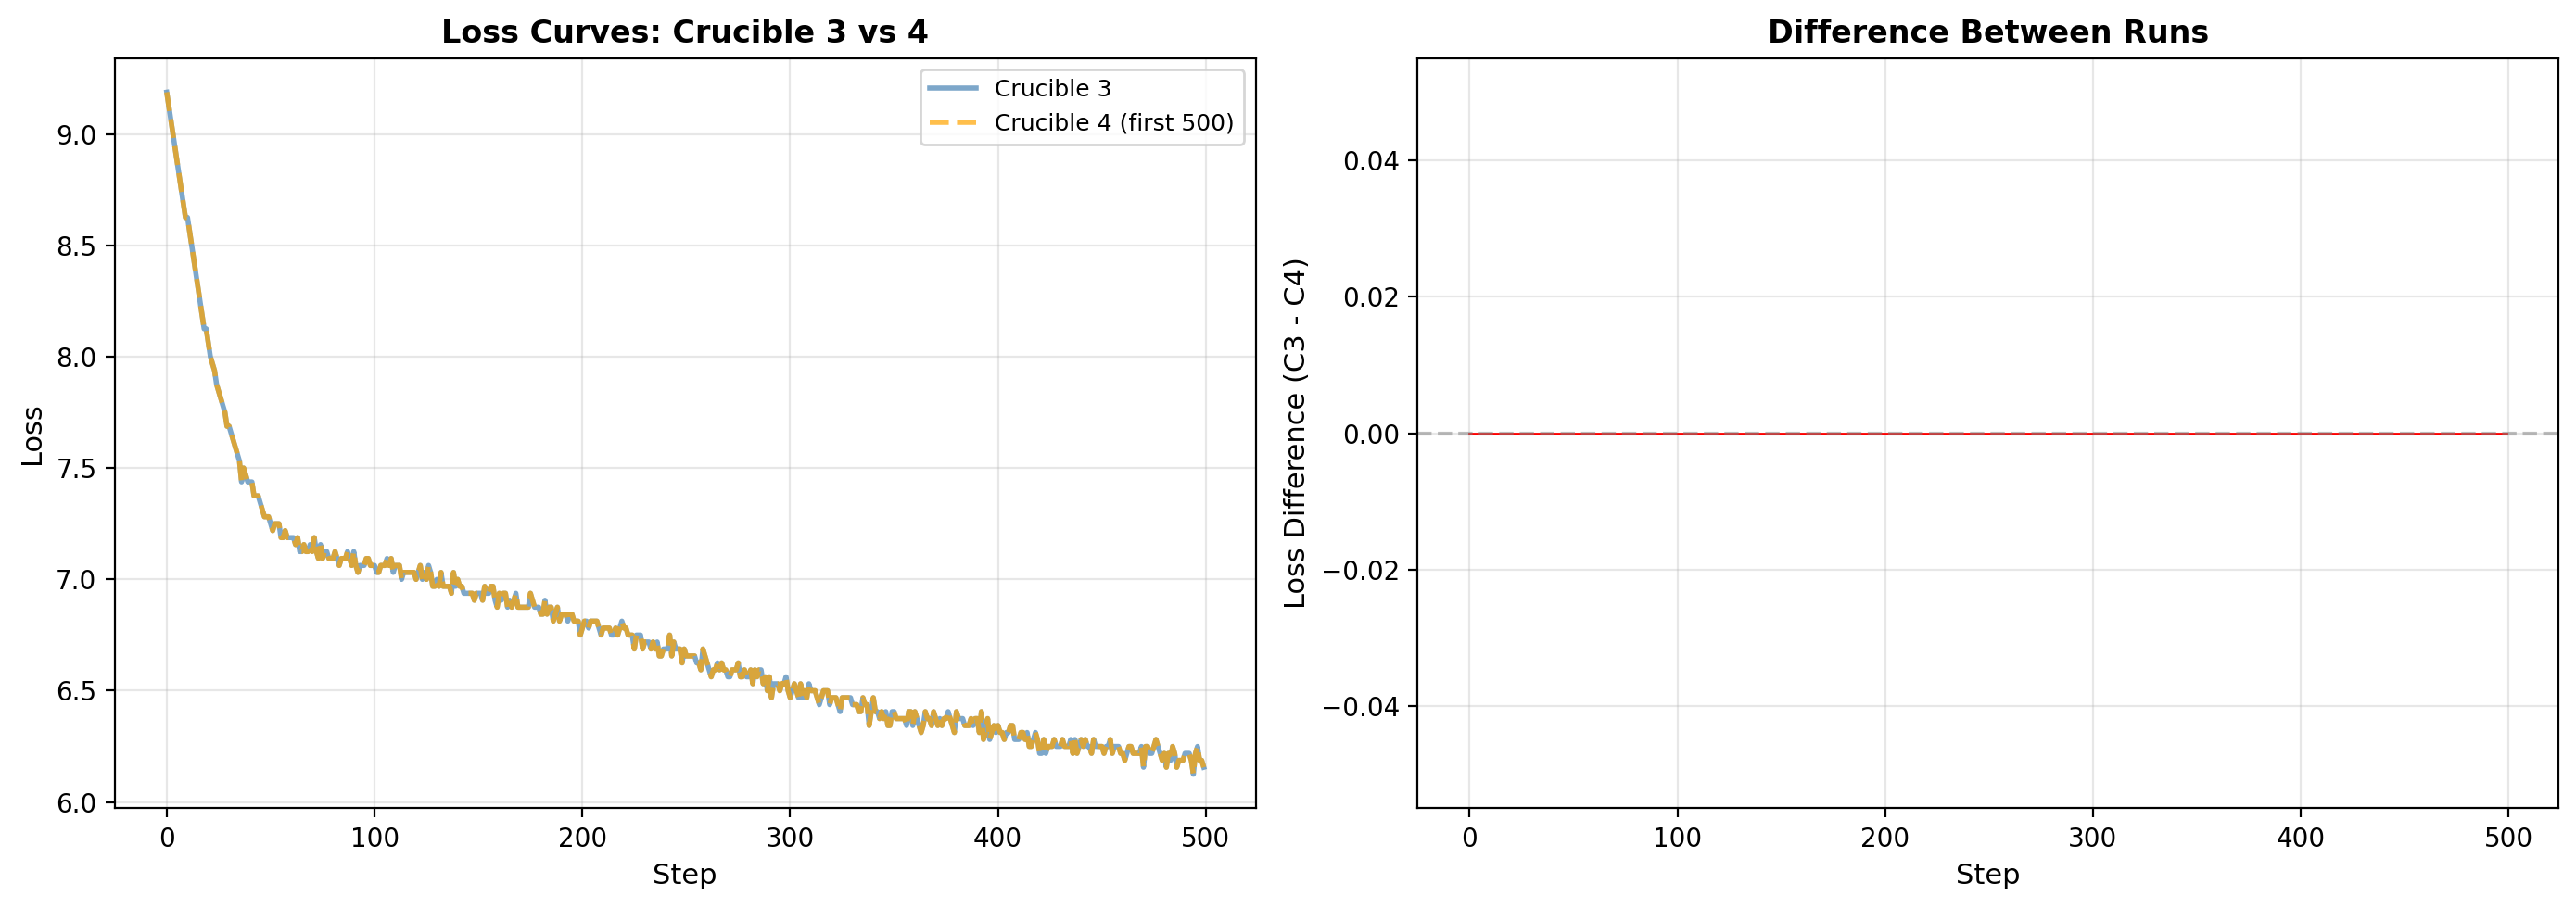

Loss difference stats:
  Max abs: 0.00e+00
  Mean abs: 0.00e+00
  Std: 0.00e+00


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Overlay
ax1.plot(loss_3_valid.numpy(), color=STEELBLUE, linewidth=2, alpha=0.7, label='Crucible 3')
ax1.plot(loss_4_valid.numpy(), color='orange', linewidth=2, alpha=0.7, linestyle='--', label='Crucible 4 (first 500)')
ax1.set_xlabel('Step', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Loss Curves: Crucible 3 vs 4', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Right: Difference
diff = (loss_3_valid - loss_4_valid).numpy()
ax2.plot(diff, color='red', linewidth=1)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Step', fontsize=11)
ax2.set_ylabel('Loss Difference (C3 - C4)', fontsize=11)
ax2.set_title('Difference Between Runs', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Loss difference stats:")
print(f"  Max abs: {abs(diff).max():.2e}")
print(f"  Mean abs: {abs(diff).mean():.2e}")
print(f"  Std: {diff.std():.2e}")

## Summary

In [9]:
print("=" * 60)
print("REPRODUCIBILITY VERDICT")
print("=" * 60)

all_match = W_match and h_mean_match and loss_match

if all_match:
    print("\n✅ PERFECT REPRODUCIBILITY")
    print("\nCrucible 4's first 500 steps EXACTLY match Crucible 3.")
    print("All 320,640,000 W values, 32,000 h_mean values, and 500 loss values are identical.")
    print("\nThis confirms:")
    print("  1. Training dynamics are deterministic (same seed → same results)")
    print("  2. Crucible 4's extended data (steps 501-5000) can be trusted")
    print("  3. Any differences in long-term behavior are real, not artifacts")
else:
    print("\n⚠️  REPRODUCIBILITY ISSUES DETECTED")
    print("\nSee diagnostics above for details.")
    print("\nPossible causes:")
    print("  - Non-deterministic operations (unlikely with fixed seed)")
    print("  - Different PyTorch/CUDA versions")
    print("  - Hardware-specific floating point behavior")
    print("  - Data loading order changed")
    
print("\n" + "=" * 60)

REPRODUCIBILITY VERDICT

✅ PERFECT REPRODUCIBILITY

Crucible 4's first 500 steps EXACTLY match Crucible 3.
All 320,640,000 W values, 32,000 h_mean values, and 500 loss values are identical.

This confirms:
  1. Training dynamics are deterministic (same seed → same results)
  2. Crucible 4's extended data (steps 501-5000) can be trusted
  3. Any differences in long-term behavior are real, not artifacts

